# LSTM(长短期记忆网络)
长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。 解决这一问题的最早方法之一是长短期存储器（`long short-term memory，LSTM`） (Hochreiter and Schmidhuber, 1997)。 它有许多与**门控循环单元**（ 9.1节）一样的属性。 有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些， 却比门控循环单元早诞生了近20年。

长短期记忆网络引入了**记忆元（memory cell）**，或简称为**单元（cell）**。 有些文献认为记忆元是隐状态的一种特殊类型， 它们与隐状态具有相同的形状，其设计目的是用于记录附加的信息。 为了控制记忆元，我们需要许多门。 其中一个门用来从单元中输出条目，我们将其称为**输出门（output gate）**。 另外一个门用来决定何时将数据读入单元，我们将其称为**输入门（input gate）**。 我们还需要一种机制来重置单元的内容，由**遗忘门(forget gate)**来管理， 这种设计的动机与门控循环单元相同， 能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。

## 输入门、遗忘门和输出门
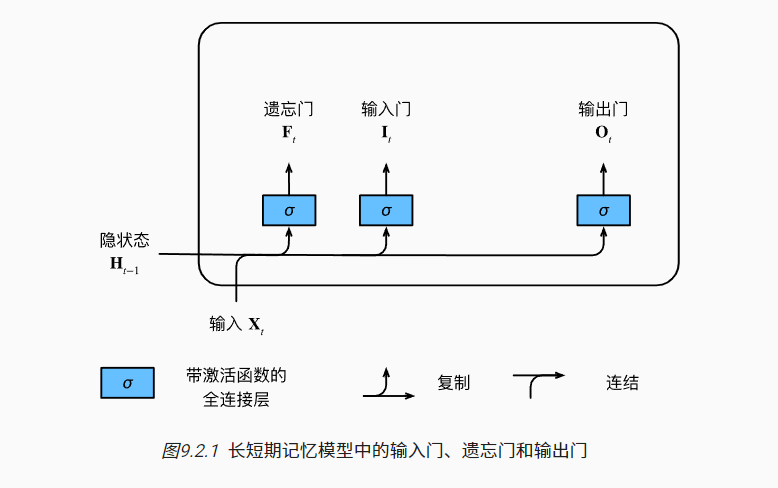
计算公式如下
$$
\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}\end{split}
$$
## 候选记忆元
由于还没有指定各种门的操作，所以先介绍**候选记忆元（candidate memory cell）**$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。 它的计算与上面描述的三个门的计算类似， 但是使用tanh函数作为激活函数，函数的值范围为(-1, 1)。  
$$
\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c)
$$
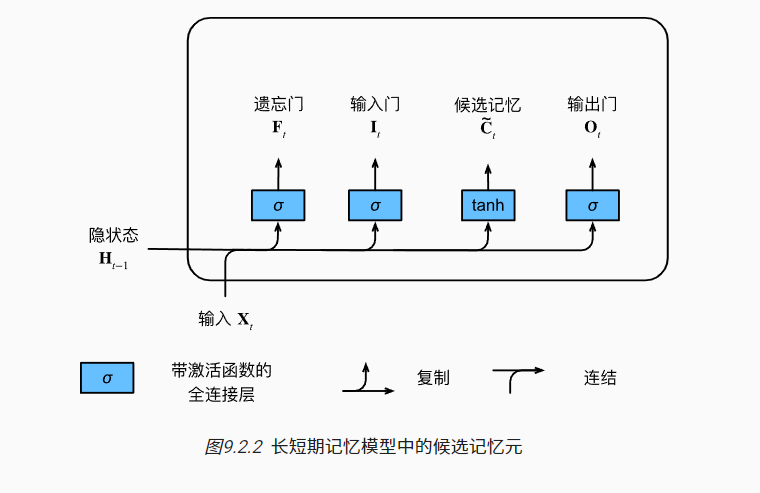

## 记忆元(Memory Cell)
类似地，在长短期记忆网络中，也有两个门用于这样的目的： 输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据， 而遗忘门$\mathbf{F}_t$控制保留多少过去的记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。 使用按元素乘法，得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$
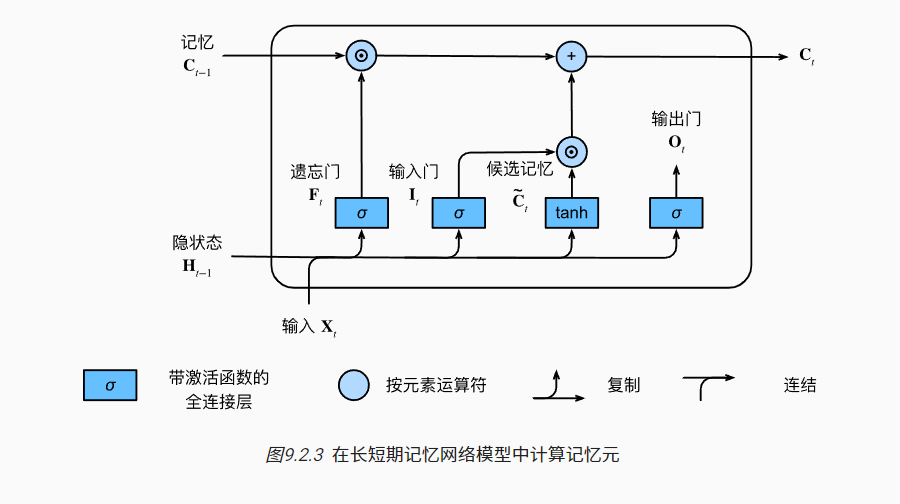

如果遗忘门始终为1且输入门始终为0， 则过去的记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$将随时间被保存并传递到当前时间步。 引入这种设计是为了缓解梯度消失问题， 并更好地捕获序列中的长距离依赖关系。

## 隐状态(Hidden State)
最后，我们需要定义如何计算隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$ ， 这就是输出门发挥作用的地方。 在长短期记忆网络中，它仅仅是记忆元的的tanh门控版本。 这就确保了$\mathbf{H}_t$的值始终在区间(-1, 1)内：
$$
\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).
$$
只要输出门接近，我们就能够有效地将所有记忆信息传递给预测部分， 而对于输出门接近，我们只保留记忆元内的所有信息，而不需要更新隐状态。
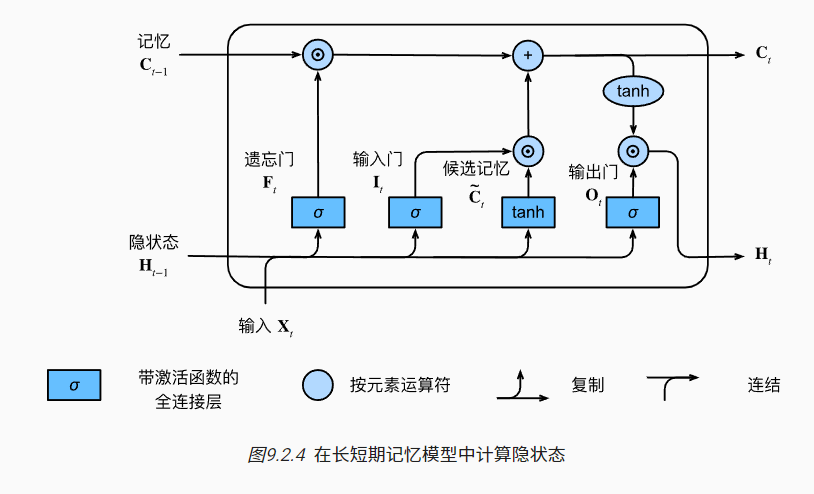

In [1]:
import torch
from torch import nn
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    def para():
        return (normal((num_inputs, num_hiddens)), 
                normal((num_hiddens, num_hiddens)), 
                torch.zeros(num_hiddens, device=device))
    # 遗忘门f, 输入门I, 候选记忆C, 输出门O
    W_xf, W_hf, bf = para()
    W_xi, W_hi, bi = para()
    W_xc, W_hc, bc = para()
    W_xo, W_ho, bo = para()
    # 输出层
    W_hq, bq = normal((num_hiddens, num_outputs)), torch.zeros(num_outputs, device=device)
    params = [W_xf, W_hf, bf, W_xi, W_hi, bi, W_xc, W_hc, bc, W_xo, W_ho, bo, W_hq, bq]
    for p in params:
        p.requires_grad_(True)
    return params

In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.randn(size=(batch_size, num_hiddens), device=device), 
           torch.randn(size=(batch_size, num_hiddens), device=device))

def lstm(inputs, state, params):
    W_xf, W_hf, bf, W_xi, W_hi, bi, W_xc, W_hc, bc, W_xo, W_ho, bo, W_hq, bq = params
    C, H = state
    outputs = []
    for X in inputs:
        # X(batch_size, num_inputs)
        F = torch.sigmoid(X@W_xf+H@W_hf+bf)
        I = torch.sigmoid(X@W_xi+H@W_hi+bi)
        O = torch.sigmoid(X@W_xo+H@W_ho+bo)
        C_c = torch.tanh(X@W_xc+H@W_hc+bc)
        C = F*C+I*C_c
        H = O*torch.tanh(C)
        Y = H@W_hq+bq
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (C, H)

困惑度 2.9, 38546.8 词元/秒 cuda:0
time traveller struck me and i could not clearly believe that i 
traveller stood before my visit the time traveller stood be


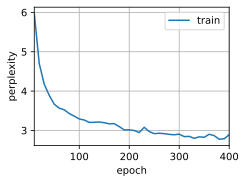

In [4]:
batch_size, num_steps, use_random = 64, 32, True
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random, -1)
vocab_size, num_hiddens, device = len(vocab), 256, torch.device("cuda:0")
lstm = d2l.RNNModelScratch(vocab_size, num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
lr, num_epochs = 30, 400
d2l.train_ch8(lstm, train_iter, vocab, lr, num_epochs, device, use_random)

time traveller some still eneray in the sun in the sun stared at 


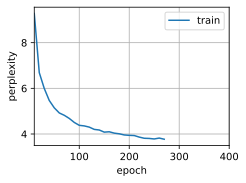

In [ ]:
batch_size, num_steps, use_random = 64, 32, True
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random, -1)
vocab_size, num_hiddens, device = len(vocab), 256, torch.device("cuda:0")
lr, num_epochs = 30, 400
lstm_layer = nn.LSTM(vocab_size, num_hiddens)
model = d2l.RNNModel(lstm_layer, vocab_size)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)